In [ ]:
import optuna
from optuna.samplers import TPESampler
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import Lasso, Ridge, RidgeCV
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")

In [21]:
## Set these to TRUE if you want to tune the models again.

RETUNE_CATBOOST = True
RETUNE_LGBM = True
RETUNE_LASSO = True

# 1. Load Dataset

In [22]:
train_df = pd.read_csv(
    "D:/Freelancer Projects/Kaggle Comp/playground-series-s4e12/train.csv"
)

original_df = pd.read_csv(
    "D:/Freelancer Projects/Kaggle Comp/playground-series-s4e12/Insurance Premium Prediction Dataset.csv"
)

train = pd.concat([train_df, original_df], ignore_index=True)
train = train.drop(["id"], axis=1)

test = pd.read_csv(
    "D:/Freelancer Projects/Kaggle Comp/playground-series-s4e12/test.csv"
).drop(columns="id")

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1478860 entries, 0 to 1478859
Data columns (total 20 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   Age                   1455470 non-null  float64
 1   Gender                1478860 non-null  object 
 2   Annual Income         1419956 non-null  float64
 3   Marital Status        1455312 non-null  object 
 4   Number of Dependents  1341302 non-null  float64
 5   Education Level       1478860 non-null  object 
 6   Occupation            1039497 non-null  object 
 7   Health Score          1394187 non-null  float64
 8   Location              1478860 non-null  object 
 9   Policy Type           1478860 non-null  object 
 10  Previous Claims       1033543 non-null  float64
 11  Vehicle Age           1478854 non-null  float64
 12  Credit Score          1313092 non-null  float64
 13  Insurance Duration    1478859 non-null  float64
 14  Policy Start Date     1478860 non-

In [45]:
missing_values_prop = train.isnull().mean()
a = missing_values_prop*100.0
print("missings proportion:\n", a)

missings proportion:
 Age                      0.000000
Gender                   0.000000
Annual Income            3.983068
Marital Status           1.592308
Number of Dependents     9.301624
Education Level          0.000000
Occupation              29.709574
Health Score             5.725559
Location                 0.000000
Policy Type              0.000000
Previous Claims         30.112181
Vehicle Age              0.000406
Credit Score            11.209175
Insurance Duration       0.000068
Policy Start Date        0.000000
Customer Feedback        6.503185
Smoking Status           0.000000
Exercise Frequency       0.000000
Property Type            0.000000
Premium Amount           0.000000
dtype: float64


In [8]:
missing_values_prop = test.isnull().mean()
a = missing_values_prop*100.0
print("missings proportion:\n", a)

missings proportion:
 Age                      1.561125
Gender                   0.000000
Annual Income            3.732500
Marital Status           1.542000
Number of Dependents     9.141250
Education Level          0.000000
Occupation              29.890625
Health Score             6.181125
Location                 0.000000
Policy Type              0.000000
Previous Claims         30.350250
Vehicle Age              0.000375
Credit Score            11.431375
Insurance Duration       0.000250
Policy Start Date        0.000000
Customer Feedback        6.534500
Smoking Status           0.000000
Exercise Frequency       0.000000
Property Type            0.000000
dtype: float64


# 2. Inspect Features

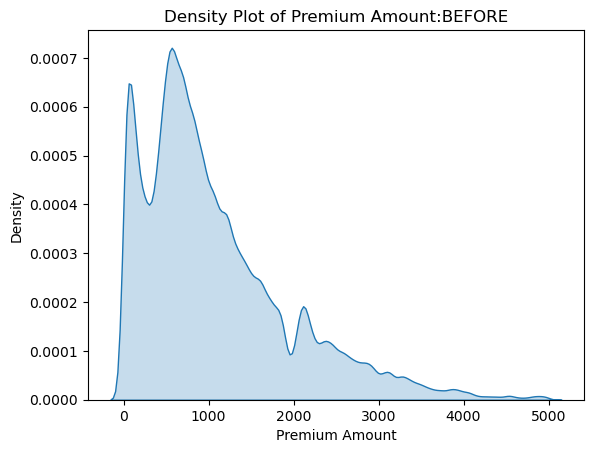

In [38]:
# Plot a density plot
sns.kdeplot(train['Premium Amount'], fill=True)

# Add labels and title
plt.xlabel('Premium Amount')
plt.ylabel('Density')
plt.title('Density Plot of Premium Amount:BEFORE')
plt.show()

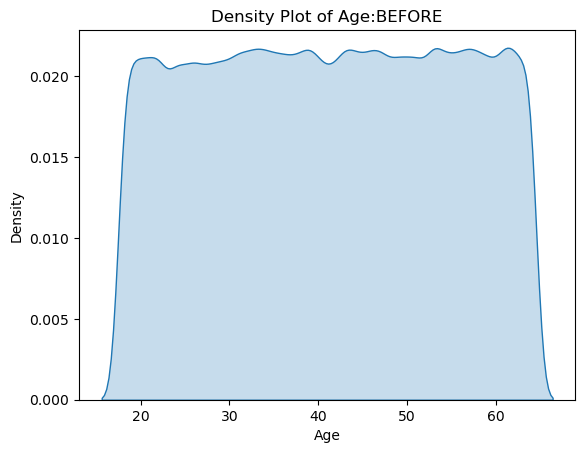

In [43]:
# Plot a density plot
sns.kdeplot(train['Age'], fill=True)

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Density Plot of Age:BEFORE')
plt.show()

In [7]:
with pd.option_context('display.max_rows', 200):
    display(train['Age'].value_counts())

Age
53.0    32323
61.0    32148
39.0    31926
43.0    31864
57.0    31807
64.0    31761
62.0    31755
33.0    31704
46.0    31583
47.0    31548
34.0    31539
44.0    31439
31.0    31338
58.0    31333
56.0    31330
32.0    31314
54.0    31264
38.0    31239
22.0    31227
35.0    31212
36.0    31170
55.0    31126
45.0    31053
59.0    30993
51.0    30976
49.0    30974
37.0    30916
20.0    30822
50.0    30806
40.0    30800
21.0    30709
26.0    30607
30.0    30544
48.0    30540
19.0    30533
29.0    30496
24.0    30467
42.0    30393
60.0    30341
18.0    30296
28.0    30281
52.0    30269
63.0    30031
27.0    30020
25.0    29992
41.0    29780
23.0    28881
Name: count, dtype: int64

In [8]:
with pd.option_context('display.max_rows', 200):
    display(train['Gender'].value_counts())

Gender
Male      742325
Female    736535
Name: count, dtype: int64

In [9]:
with pd.option_context('display.max_rows', 200):
    display(train['Annual Income'].value_counts())

Annual Income
7073.0      1050
16054.0     1031
14094.0      926
24897.0      923
15983.0      896
            ... 
121505.0       1
25951.0        1
68064.0        1
112436.0       1
66056.0        1
Name: count, Length: 110780, dtype: int64

In [10]:
with pd.option_context('display.max_rows', 200):
    display(train['Marital Status'].value_counts())

Marital Status
Single      486888
Married     485577
Divorced    482847
Name: count, dtype: int64

In [11]:
with pd.option_context('display.max_rows', 200):
    display(train['Number of Dependents'].value_counts())

Number of Dependents
3.0    271810
4.0    270201
0.0    268260
2.0    265680
1.0    265351
Name: count, dtype: int64

In [12]:
with pd.option_context('display.max_rows', 200):
    display(train['Education Level'].value_counts())

Education Level
Master's       373633
PhD            373462
Bachelor's     373164
High School    358601
Name: count, dtype: int64

In [13]:
with pd.option_context('display.max_rows', 200):
    display(train['Occupation'].value_counts())

Occupation
Employed         348649
Self-Employed    348553
Unemployed       342295
Name: count, dtype: int64

In [14]:
with pd.option_context('display.max_rows', 200):
    display(train['Health Score'].value_counts())

Health Score
19.927241    129
25.907650    125
19.869701    120
22.955402    105
27.845006    104
            ... 
25.066171      1
7.908572       1
32.235938      1
33.966984      1
25.962097      1
Name: count, Length: 682443, dtype: int64

In [15]:
with pd.option_context('display.max_rows', 200):
    display(train['Location'].value_counts())

Location
Suburban    495024
Rural       493606
Urban       490230
Name: count, dtype: int64

In [16]:
with pd.option_context('display.max_rows', 200):
    display(train['Policy Type'].value_counts())

Policy Type
Premium          495144
Comprehensive    492079
Basic            491637
Name: count, dtype: int64

In [17]:
with pd.option_context('display.max_rows', 200):
    display(train['Previous Claims'].value_counts())

Previous Claims
0.0    378226
1.0    373736
2.0    203644
3.0     61076
4.0     13731
5.0      2643
6.0       396
7.0        79
8.0         9
9.0         3
Name: count, dtype: int64

In [18]:
with pd.option_context('display.max_rows', 200):
    display(train['Vehicle Age'].value_counts())

Vehicle Age
17.0    76679
11.0    75623
0.0     75502
18.0    75408
10.0    75257
14.0    74822
15.0    74734
12.0    74674
19.0    74506
16.0    74399
2.0     73848
9.0     73688
7.0     73682
5.0     73475
3.0     72946
13.0    72434
8.0     72246
4.0     71990
6.0     71867
1.0     71074
Name: count, dtype: int64

In [19]:
with pd.option_context('display.max_rows', 200):
    display(train['Credit Score'].value_counts())

Credit Score
434.0    4750
431.0    4712
757.0    4522
713.0    4480
437.0    4354
         ... 
660.0     908
560.0     858
610.0     801
606.0     797
700.0     790
Name: count, Length: 550, dtype: int64

In [23]:
with pd.option_context('display.max_rows', 200):
    display(train['Insurance Duration'].value_counts())

Insurance Duration
9.0    168936
1.0    165765
8.0    164840
7.0    164709
5.0    163408
4.0    163029
3.0    163027
6.0    162981
2.0    162164
Name: count, dtype: int64

In [24]:
with pd.option_context('display.max_rows', 200):
    display(train['Policy Start Date'].value_counts())

Policy Start Date
2020-02-08 15:21:39.134960    155
2023-08-13 15:21:39.155231    151
2022-08-30 15:21:39.134960    150
2022-02-02 15:21:39.134960    149
2024-02-19 15:21:39.134960    131
                             ... 
2022-08-15 15:21:39.163910      1
2019-10-14 15:21:39.163910      1
2022-12-23 15:21:39.163910      1
2022-02-23 15:21:39.163910      1
2024-01-14 15:21:39.291118      1
Name: count, Length: 181607, dtype: int64

In [25]:
with pd.option_context('display.max_rows', 200):
    display(train['Customer Feedback'].value_counts())

Customer Feedback
Average    464811
Poor       462390
Good       455486
Name: count, dtype: int64

In [26]:
with pd.option_context('display.max_rows', 200):
    display(train['Smoking Status'].value_counts())

Smoking Status
Yes    741508
No     737352
Name: count, dtype: int64

In [27]:
with pd.option_context('display.max_rows', 200):
    display(train['Exercise Frequency'].value_counts())

Exercise Frequency
Weekly     376417
Monthly    369232
Rarely     369226
Daily      363985
Name: count, dtype: int64

In [30]:
with pd.option_context('display.max_rows', 200):
    display(train['Property Type'].value_counts())

Property Type
House        493577
Apartment    492857
Condo        492426
Name: count, dtype: int64

## Heatmap

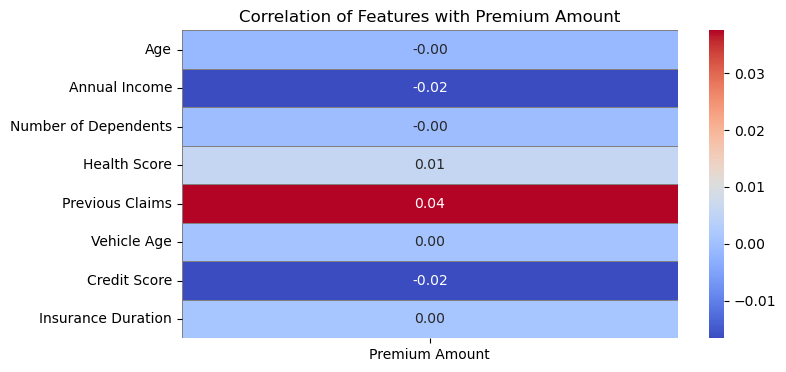

In [36]:
def plot_feature_target_correlation(df, target_column):
    # Select only numerical columns
    numeric_df = df.select_dtypes(include=["number"])

    # Ensure the target column is included in the filtered DataFrame
    if target_column not in numeric_df.columns:
        raise ValueError(f"The target column '{target_column}' is not numeric.")

    # Calculate correlation matrix
    correlation_matrix = numeric_df.corr()

    # Extract correlations of features with the target column
    target_correlation = correlation_matrix[[target_column]].drop(target_column)  # Exclude the target itself

    # Create a heatmap
    plt.figure(figsize=(8, len(target_correlation) * 0.5))
    sns.heatmap(
        target_correlation,
        annot=True,
        cmap="coolwarm",
        cbar=True,
        fmt=".2f",
        linewidths=0.5,
        linecolor="gray",
    )
    plt.title(f"Correlation of Features with {target_column}")
    plt.show()

# Example usage
plot_feature_target_correlation(train, "Premium Amount")

# 3. Preprocessing

## Missing Values

In [39]:
train['Premium Amount'].fillna(600, inplace=True)

In [44]:
# Count missing values
missing_count = train["Age"].isna().sum()

# Generate random values for the missing entries
random_values = np.random.randint(19, 63, size=missing_count)

# Fill missing values
train["Age"] = train["Age"].fillna(pd.Series(random_values, index=train.index[train["Age"].isna()]))


In [6]:
# Step 1: Calculate the mode of the column
mode_value = train['Financial Stress'].mode()[0]
print(mode_value)

# Step 2: Impute missing values with the mode
train['Financial Stress'].fillna(mode_value, inplace=True)

2.0


In [7]:
train['Profession'].fillna('Student', inplace=True)
train = train.drop(columns='Working Professional or Student')

test['Profession'].fillna('Student', inplace=True)
test = test.drop(columns='Working Professional or Student')

In [8]:
train['Work Pressure'] = train['Work Pressure'].fillna(train['Academic Pressure'])
train.rename(columns={'Work Pressure': 'Academic/Work Pressure'}, inplace=True)
train = train.drop(columns='Academic Pressure')

test['Work Pressure'] = test['Work Pressure'].fillna(test['Academic Pressure'])
test.rename(columns={'Work Pressure': 'Academic/Work Pressure'}, inplace=True)
test = test.drop(columns='Academic Pressure')

In [9]:
# Step 1: Calculate the mode of the column
mode_value = train['Academic/Work Pressure'].mode()[0]
print(mode_value)

# Step 2: Impute missing values with the mode
train['Academic/Work Pressure'].fillna(mode_value, inplace=True)

# Step 1: Calculate the mode of the column
mode_value = test['Academic/Work Pressure'].mode()[0]
print(mode_value)

# Step 2: Impute missing values with the mode
test['Academic/Work Pressure'].fillna(mode_value, inplace=True)

3.0
3.0


In [10]:
train['CGPA'].fillna(0, inplace=True)
test['CGPA'].fillna(0, inplace=True)

In [11]:
train['Job Satisfaction'] = train['Job Satisfaction'].fillna(train['Study Satisfaction'])
train.rename(columns={'Job Satisfaction': 'Study/Job Satisfaction'}, inplace=True)
train = train.drop(columns='Study Satisfaction')

test['Job Satisfaction'] = test['Job Satisfaction'].fillna(test['Study Satisfaction'])
test.rename(columns={'Job Satisfaction': 'Study/Job Satisfaction'}, inplace=True)
test = test.drop(columns='Study Satisfaction')

In [12]:
mode_value = train['Study/Job Satisfaction'].mode()[0]
print(mode_value)

# Step 2: Impute missing values with the mode
train['Study/Job Satisfaction'].fillna(mode_value, inplace=True)

mode_value = test['Study/Job Satisfaction'].mode()[0]
print(mode_value)

# Step 2: Impute missing values with the mode
test['Study/Job Satisfaction'].fillna(mode_value, inplace=True)

2.0
2.0


# 4. Feature Engineering

In [13]:
def add_features(df):
    df2 = df.copy()

    df2["Age"] = df2["Age"].astype("int")
    df2["Academic/Work Pressure"] = df2["Academic/Work Pressure"].astype("int")
    df2["Study/Job Satisfaction"] = df2["Study/Job Satisfaction"].astype("int")
    df2["Work/Study Hours"] = df2["Work/Study Hours"].astype("int")
    df2["Financial Stress"] = df2["Financial Stress"].astype("int")
    
    df2["Age_bin"] = pd.qcut(df2["Age"], 5, labels=False)
    df2["satisfaction_by_pressure"] = df2["Academic/Work Pressure"] / df2["Study/Job Satisfaction"]
    df2["age_work_satisfaction"] = df2["Age"] / df2["Study/Job Satisfaction"]
    

    return df2

In [14]:
train_processed = add_features(train)
test_processed = add_features(test)

# 5. Catboost

In [15]:
preds_train, preds_test = pd.DataFrame(), pd.DataFrame()

In [16]:
X_train = train_processed.drop(columns=["Depression"])
y_train = train_processed.Depression

#### 5.1 Encoding Categorical Columns for CatBoost

In [17]:
X_train = X_train.astype("string").astype("category")
df_test_catboost = test_processed.astype("string").astype("category")

In [18]:
cat_cols = X_train.columns[X_train.dtypes == "category"].tolist()
print(cat_cols)

['Name', 'Gender', 'Age', 'City', 'Profession', 'Academic/Work Pressure', 'CGPA', 'Study/Job Satisfaction', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Work/Study Hours', 'Financial Stress', 'Family History of Mental Illness', 'Age_bin', 'satisfaction_by_pressure', 'age_work_satisfaction']


#### 5.2 Catboost Hyperparameter Tuning with Optuna

In [19]:
def catboost_objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 500, 5000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "depth": trial.suggest_int("depth", 3, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0, 5),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 0, 2),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 5),
        "auto_class_weights": trial.suggest_categorical(
            "auto_class_weights", ["Balanced", None]
        ),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracy_scores = []  # To store accuracy scores for each fold
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # creating LightGBM classifier with suggested hyperparameters
        model = CatBoostClassifier(
            **params,
            random_seed=42,
            loss_function="Logloss",
            cat_features=cat_cols,
            task_type="GPU",
            thread_count=-1,
            eval_metric="Accuracy",  # Set evaluation metric to Accuracy
        )
        model.fit(
            X_train_fold,
            y_train_fold,
            eval_set=(X_val_fold, y_val_fold),
            early_stopping_rounds=150,
            verbose=False,
        )
        # Predict labels
        y_pred = model.predict(X_val_fold)
        acc = accuracy_score(y_val_fold, y_pred)  # Calculate accuracy
        accuracy_scores.append(acc)

    print(f"Trial {trial.number}: {accuracy_scores} , mean : {np.mean(accuracy_scores)}")
    return np.mean(accuracy_scores)


In [25]:
## I have already optimized the hyperparameters. To run the tuning again, set RETUNE_HYPERPARAMETERS to True.

if RETUNE_CATBOOST:
    catboost_study = optuna.create_study(
        direction="maximize",
        sampler=TPESampler(n_startup_trials=25, seed=42, multivariate=True),
    )
    catboost_study.optimize(catboost_objective, n_trials=100)

    catboost_combined_data_best_params = catboost_study.best_params

else:
    ## optimal hyperparameters
    catboost_combined_data_best_params = {
        "iterations": 3400,
        "learning_rate": 0.23182266111642433,
        "depth": 3,
        "l2_leaf_reg": 2.8517407656681266,
        "border_count": 88,
        "random_strength": 0.07663485681876864,
        "bagging_temperature": 0.6270119414641275,
        "auto_class_weights": None,
    }
    
    cat_params = {
        'iterations': 715,
        'learning_rate': 0.05009420761428966,
        'colsample_bylevel': 0.5859169200239407,
        'subsample': 0.7705184727295318,
        'min_data_in_leaf': 30,
        'depth': 7,
        'l2_leaf_reg': 0.004379496536587387,
        'random_strength': 0.4519161767798322
    }


In [21]:
print(catboost_combined_data_best_params)

{'iterations': 3400, 'learning_rate': 0.23182266111642433, 'depth': 3, 'l2_leaf_reg': 2.8517407656681266, 'border_count': 88, 'random_strength': 0.07663485681876864, 'bagging_temperature': 0.6270119414641275, 'auto_class_weights': None}


In [22]:
# Ensure all categorical columns are in cat_features
cat_cols = X_train.columns[X_train.dtypes == "category"].tolist()
print(f"Categorical columns: {cat_cols}")

Categorical columns: ['Name', 'Gender', 'Age', 'City', 'Profession', 'Academic/Work Pressure', 'CGPA', 'Study/Job Satisfaction', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Work/Study Hours', 'Financial Stress', 'Family History of Mental Illness', 'Age_bin', 'satisfaction_by_pressure', 'age_work_satisfaction']


In [27]:
## using stratified K-Fold Cross Validation because the dataset is imbalanced.

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores = []
oof_preds = np.zeros(len(y_train))
test_preds = np.zeros(len(test))

catboost_model_final = CatBoostClassifier(
    **cat_params,
    random_seed=42,
    loss_function="Logloss",
    cat_features=cat_cols,
    #task_type="GPU",
    metric_period=1,
    eval_metric="Accuracy",  # Set evaluation metric to Accuracy
    verbose=False,
)

for train_index, test_index in skf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    catboost_model_final.fit(
        X_train_fold,
        y_train_fold,
        eval_set=(X_test_fold, y_test_fold),
        early_stopping_rounds=150,
    )
    # Predict labels for accuracy computation
    y_pred = catboost_model_final.predict(X_test_fold)
    acc = accuracy_score(y_test_fold, y_pred)
    accuracy_scores.append(acc)

    oof_preds[test_index] = y_pred  # Store out-of-fold predictions
    test_preds += (catboost_model_final.predict(df_test_catboost) / skf.get_n_splits())

preds_train["catboost_combined_data"] = oof_preds
preds_test["catboost_combined_data"] = test_preds

print(f"Scores: {accuracy_scores}, mean: {np.mean(accuracy_scores)}")

Scores: [0.9412955465587044, 0.9390248158877527, 0.9423056786848627, 0.9396879690063175, 0.9407699556734495], mean: 0.9406167931622174


# 6. LightGBM

In [75]:
X_train = train_processed.drop(columns=["Depression"])
y_train = train_processed.Depression

#### 6.1 Encoding Categorical Columns for LGBM

In [76]:
one_hot_columns = [
    "Name",
    "Gender",
    "City",
    "Profession",
    "Sleep Duration",
    "Dietary Habits",
    "Degree",
    "Have you ever had suicidal thoughts ?",
    "Family History of Mental Illness",
]

ordinal_columns = [
    "Academic/Work Pressure",
     "Study/Job Satisfaction",
]

ct = ColumnTransformer(
    [
        (
            "onehot",
            OneHotEncoder(handle_unknown="ignore", drop="first"),
            one_hot_columns,
        ),
        ("ordinal", OrdinalEncoder(), ordinal_columns),
    ],
    remainder="passthrough",
)

In [77]:
X_train = ct.fit_transform(X_train).toarray()
X_train = pd.DataFrame(X_train, columns=ct.get_feature_names_out())
X_train.head()

,onehot__Name_A.Ed,onehot__Name_Aadhya,onehot__Name_Aahana,onehot__Name_Aakash,onehot__Name_Aam,onehot__Name_Aan,onehot__Name_Aanchal,onehot__Name_Aani,onehot__Name_Aanket,onehot__Name_Aanya,...,onehot__Family History of Mental Illness_Yes,ordinal__Academic/Work Pressure,ordinal__Study/Job Satisfaction,remainder__Age,remainder__CGPA,remainder__Work/Study Hours,remainder__Financial Stress,remainder__Age_bin,remainder__satisfaction_by_pressure,remainder__age_work_satisfaction
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,1.0,49.0,0.00,1.0,2.0,3.0,2.500000,24.500000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,2.0,26.0,0.00,7.0,3.0,0.0,1.333333,8.666667
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,1.0,33.0,8.97,3.0,1.0,1.0,2.500000,16.500000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,4.0,0.0,22.0,0.00,10.0,1.0,0.0,5.000000,22.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,30.0,0.00,9.0,4.0,1.0,1.000000,30.000000


In [78]:
df_test_processed = ct.transform(test_processed)

#### 6.2 LGBM Hyperparameter Tuning with Optuna

In [79]:
def lgbm_objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1200),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 256),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 200),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 10),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 10),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 3),
        "is_unbalance": trial.suggest_categorical("is_unbalance", ["+", "-"]),
    }

    # creating LightGBM classifier with suggested hyperparameters
    lgbm_model = LGBMClassifier(
        **params,
        objective="binary",
        random_state=42,
        n_jobs=-1,
        device="gpu",  # Enable GPU training
        gpu_id=0,      # Specify the GPU ID (default is 0)
        verbosity=-1,
        metric="binary_logloss",
        early_stopping_round=50,
    )

    # stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracy_scores = []  # To store accuracy scores for each fold

    for train_index, test_index in skf.split(X_train, y_train):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        lgbm_model.fit(
            X_train_fold,
            y_train_fold,
            eval_set=[(X_test_fold, y_test_fold)],
            eval_metric="binary_logloss",
        )
        y_pred = lgbm_model.predict(X_test_fold)
        acc = accuracy_score(y_test_fold, y_pred)  # Calculate accuracy
        accuracy_scores.append(acc)

    print(f"Trial {trial.number}: {accuracy_scores} , mean : {np.mean(accuracy_scores)}")
    return np.mean(accuracy_scores)


In [80]:
if RETUNE_LGBM:
    lgbm_study = optuna.create_study(
        direction="maximize",
        sampler=TPESampler(n_startup_trials=30, seed=42, multivariate=True),
    )
    lgbm_study.optimize(lgbm_objective, n_trials=100)

    print("Best Hyperparameters:", lgbm_study.best_params)
    print("Best Accuracy:", lgbm_study.best_value)
    lgbm_combined_data_best_params = lgbm_study.best_params
else:
    lgbm_combined_data_best_params = {
        "n_estimators": 564,
        "learning_rate": 0.17684726289602054,
        "num_leaves": 144,
        "max_depth": 3,
        "min_child_samples": 148,
        "subsample": 0.8663927112474474,
        "colsample_bytree": 0.6468931065136218,
        "reg_alpha": 2.6680158055158745,
        "reg_lambda": 7.175333813772933,
        "bagging_freq": 2,
        "is_unbalance": "-",
    }

Best Hyperparameters: {'n_estimators': 564, 'learning_rate': 0.17684726289602054, 'num_leaves': 144, 'max_depth': 3, 'min_child_samples': 148, 'subsample': 0.8663927112474474, 'colsample_bytree': 0.6468931065136218, 'reg_alpha': 2.6680158055158745, 'reg_lambda': 7.175333813772933, 'bagging_freq': 2, 'is_unbalance': '-'}
Best Accuracy: 0.9402487562189055

In [81]:
## using stratified K-Fold Cross Validation because the dataset is imbalanced.

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores = []
oof_preds = np.zeros(len(y_train))
test_preds = np.zeros(len(test))

lgbm_model_final = LGBMClassifier(
    **lgbm_combined_data_best_params,
    random_state=42,
    # n_jobs=-1,
    verbosity=-2,
    objective="binary",
    metric="binary_logloss",
    early_stopping_round=200,
    device="gpu",
)

for train_index, test_index in skf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    lgbm_model_final.fit(
        X_train_fold,
        y_train_fold,
        eval_set=[(X_test_fold, y_test_fold)],
        eval_metric="binary_logloss",
    )
    y_pred = lgbm_model_final.predict(X_test_fold)
    acc = accuracy_score(y_test_fold, y_pred)  # Calculate accuracy
    accuracy_scores.append(acc)

    oof_preds[test_index] = lgbm_model_final.predict(X_test_fold)
    test_preds += (
        lgbm_model_final.predict(df_test_processed) / skf.get_n_splits()
    )

preds_train["lgbm_combined_data"] = oof_preds
preds_test["lgbm_combined_data"] = test_preds

print(f"scores: {accuracy_scores} , mean : {np.mean(accuracy_scores)}")


scores: [0.9403532039648193, 0.9391644270706083, 0.9425499982548602, 0.9395832606191756, 0.9402813165334544] , mean : 0.9403864412885836


In [82]:
preds_train.head()

,lgbm_combined_data
0,0.0
1,1.0
2,0.0
3,1.0
4,0.0


In [83]:
preds_test.head()

,lgbm_combined_data
0,0.0
1,0.0
2,0.0
3,1.0
4,0.0


# 7. Combining Catboost & LGBM

Now, we will blend the catboost and LGBM model outputs with lasso model.

We will use lasso to figure out appropriate weights to be used to combine the predictions for optimal AUC score.

In [ ]:
def lasso_objective(trial):
    alpha = trial.suggest_float("alpha", 0.001, 10)
    blending_model = Lasso(alpha=alpha)
    acc_score = cross_val_score(
        blending_model,
        preds_train,
        y_train,
        n_jobs=-1,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring="neg_mean_squared_error",
    ).mean()
    return acc_score

In [53]:
if RETUNE_LASSO:
    lasso_study = optuna.create_study(direction="maximize")
    lasso_study.optimize(lasso_objective, n_trials=100)

    print("Best alpha:", lasso_study.best_params["alpha"])
    print("Best score:", lasso_study.best_value)

    best_alpha = lasso_study.best_params["alpha"]

else:
    best_alpha = 0.460

[I 2024-11-25 19:20:36,922] A new study created in memory with name: no-name-884691e8-6426-4c71-88d7-0513eeaf74e7
[I 2024-11-25 19:20:39,287] Trial 0 finished with value: -0.1486932993866589 and parameters: {'alpha': 751.3241676338966}. Best is trial 0 with value: -0.1486932993866589.
[I 2024-11-25 19:20:40,787] Trial 1 finished with value: -0.1486932993866589 and parameters: {'alpha': 422.42642247694107}. Best is trial 0 with value: -0.1486932993866589.
[I 2024-11-25 19:20:41,020] Trial 2 finished with value: -0.1486932993866589 and parameters: {'alpha': 980.98268751197}. Best is trial 0 with value: -0.1486932993866589.
[I 2024-11-25 19:20:41,251] Trial 3 finished with value: -0.1486932993866589 and parameters: {'alpha': 992.1083361271191}. Best is trial 0 with value: -0.1486932993866589.
[I 2024-11-25 19:20:41,457] Trial 4 finished with value: -0.1486932993866589 and parameters: {'alpha': 586.9272691661264}. Best is trial 0 with value: -0.1486932993866589.
[I 2024-11-25 19:20:41,671]

Best alpha: 751.3241676338966
Best score: -0.1486932993866589


In [54]:
blending_final = Lasso(alpha=best_alpha)
blending_final.fit(preds_train, y_train)

Lasso(alpha=751.3241676338966)

In [55]:
test_predictions = blending_final.predict(preds_test)

In [56]:
print(test_predictions[0:10])

# Define threshold (default is 0.5, but you can tune this)
threshold = 0.5

# Convert continuous predictions to binary classes
binary_predictions = (test_predictions >= threshold).astype(int)

print(binary_predictions[0:10])

[0.18171286 0.18171286 0.18171286 0.18171286 0.18171286 0.18171286
 0.18171286 0.18171286 0.18171286 0.18171286]
[0 0 0 0 0 0 0 0 0 0]


# AutoGloun

In [ ]:
#from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
import pandas as pd

# Splitting the dataset into train and test
X = train 
y = train['Depression'] #asdaddsdw

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #2432534
# X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

#undersampler = RandomUnderSampler() #asdasd
#X_resampled, _ = undersampler.fit_resample(X_train, y_train) #asdadsa

# Save DataFrame to a specific path as a CSV file
X.to_csv("D:/Freelancer Projects/Kaggle Comp/playground-series-s4e11/X_train.csv", index=False)
X_test.to_csv("D:/Freelancer Projects/Kaggle Comp/playground-series-s4e11/X_test.csv", index=False)

In [4]:
from autogluon.tabular import TabularDataset, TabularPredictor

data_url = 'D:/Freelancer Projects/Kaggle Comp/playground-series-s4e11/'
train_data = TabularDataset(f'{data_url}X_train.csv')
train_data.head()

d:\python\envs\ag\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [ ]:
label = 'Depression'

# Initialize and train the AutoGluon TabularPredictor
predictor = TabularPredictor(label=label, eval_metric = 'f1').fit(
    train_data=train_data,
    presets='good_quality',  # Preset for higher accuracy, can adjust to 'medium_quality_faster_train' for faster training
    verbosity=2        # Verbosity level for detailed output
)

No path specified. Models will be saved in: "AutogluonModels\ag-20241125_162152\"
d:\python\envs\ag\lib\site-packages\autogluon\core\utils\utils.py:549: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):  # treat None, NaN, INF, NINF as NA
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20241125_162152\"
AutoGluon Version:  0.8.3
Python Version:     3.10.14
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
Disk Space Avail:   44.32 GB / 370.34 GB (12.0%)
Train Data Rows:    140700
Train Data Columns: 18
Label Column: Depression
Preprocessing data ...
d:\python\envs\ag\lib

In [8]:
test_data = TabularDataset(f'{data_url}X_test.csv')

y_pred = predictor.predict(test_data)
y_pred.head()

Loaded data from: D:/Freelancer Projects/Kaggle Comp/playground-series-s4e11/X_test.csv | Columns = 19 / 19 | Rows = 28140 -> 28140
d:\python\envs\ag\lib\site-packages\autogluon\features\generators\fillna.py:58: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  X.fillna(self._fillna_feature_map, inplace=True, downcast=False)
d:\python\envs\ag\lib\site-packages\autogluon\tabular\models\fastainn\tabular_nn_fastai.py:190: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  df = df.fillna(column_fills, inplace=False, downcast=False)


0    0
1    0
2    0
3    0
4    0
Name: Depression, dtype: int64

# 8. Submission

In [28]:
sample_submission = pd.read_csv(
    "D:/Freelancer Projects/Kaggle Comp/playground-series-s4e11/sample_submission.csv"
)
test_predictions = catboost_model_final.predict(df_test_catboost) ########## delete
sample_submission["Depression"] = test_predictions

sample_submission.to_csv(
    "D:/Freelancer Projects/Kaggle Comp/playground-series-s4e11/submission_Cat2.csv",
    index=False,
)
sample_submission.head()

,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,1
4,140704,0
